# Ensemble Learning and Random Forests

In [1]:
# Common imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# to plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1 Voting Classifiers

The idea behind the Voting Classifier is to combine conceptually different machine learning classifiers and use a majority vote (hard voting) or the average predicted probabilities (soft vote) to predict the class labels.

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

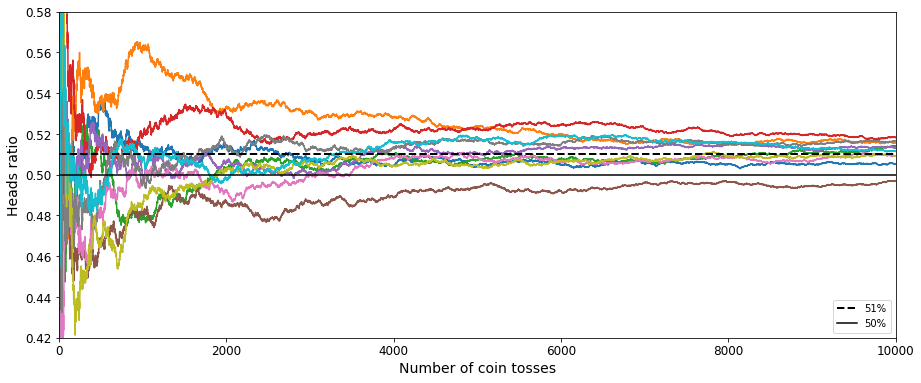

In [10]:
heads_proba = 0.51
coin_toss = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(
    coin_toss, axis=0) / np.arange(1, 10001).reshape(-1, 1)


plt.figure(figsize=(15, 6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

**Create and trains a voting classifier, composed of three diverse classifiers.**

In [12]:
# Create datasets and split it into training set and test set
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# test_size=0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**hard voting**

In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

# hard voting: uses predicted class labels for majority rule voting
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svm_clf)],
    voting="hard", n_jobs=-1)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [21]:
voting_clf.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=42, shrinking=True,
   tol=0.001, verbose=False)]

In [22]:
# The class labels
voting_clf.classes_

array([0, 1], dtype=int64)

In [24]:
from sklearn.metrics import accuracy_score

# Look at each classifier's accuracy on the test set
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


**soft voting**

In [27]:
log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

# soft voting: predicts the class label based on the argmax of the sums of the predicted probabilities
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svm_clf)],
    voting="soft", n_jobs=-1)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [28]:
# Look at each classifier's accuracy on the test set
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


In [44]:
X_test[0]  # shape: (2,)

array([0.50169252, 0.21717211])

In [46]:
X_test[:1]  # shape: (1, 2)

array([[0.50169252, 0.21717211]])

> 注意！两者的shape不一样！

In [48]:
# Look at each classifier's predict_proba on the X_test[:1]
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test[:1])
    y_proba = clf.predict_proba(X_test[:1])
    print(clf.__class__.__name__, y_proba, y_pred)

LogisticRegression [[0.49973467 0.50026533]] [1]
RandomForestClassifier [[0.6 0.4]] [0]
SVC [[0.56883291 0.43116709]] [0]
VotingClassifier [[0.55618919 0.44381081]] [0]


## 2 Bagging and Pasting

### Baggin and Pasting in skl

**bagging**

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# bagging: boostrap=True
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            n_estimators=500, max_samples=100,
                            bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [58]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


**pasting**

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# bagging: boostrap=False
pasting_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            n_estimators=500, max_samples=100,
                            bootstrap=False, n_jobs=-1)
pasting_clf.fit(X_train, y_train)

y_pred = pasting_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.92


**individual tree**

In [51]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_pred, y_pred_tree))

0.864


Compares the decision boundary of a single dt with the decision boundary of a bagging (and pasting) ensemble of 500 trees.

In [55]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

In [67]:
def plot_decision_boundary(clf, X, y, axes, alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap_2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap_2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16, rotation=0)

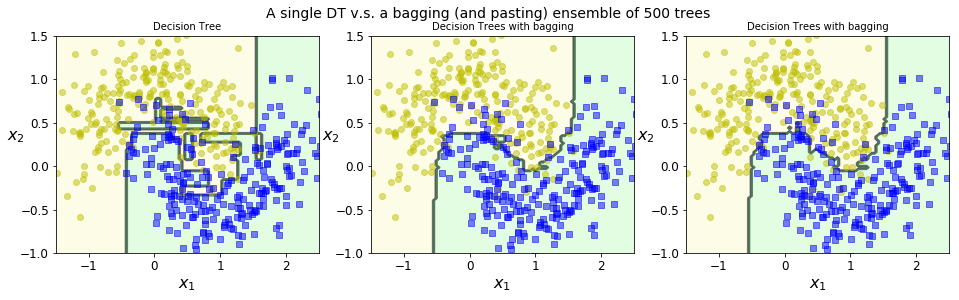

In [70]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.title("Decision Tree", fontsize=10)

plt.subplot(132)
plot_decision_boundary(bag_clf, X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.title("Decision Trees with bagging", fontsize=10)

plt.subplot(133)
plot_decision_boundary(pasting_clf, X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.title("Decision Trees with bagging", fontsize=10)

plt.suptitle("A single DT v.s. a bagging (and pasting) ensemble of 500 trees",
             fontsize=14)
plt.show()

> The ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irrregular).

### Out-of-Bag Evaluation

Set `oob_score=True` when creating a `BaggingClassifier` (bootstrap=True) to request an automatic oob evaluation after training.

In [90]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            n_estimators=500, bootstrap=True, n_jobs=-1,
                            oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [91]:
# Score of the training dataset obtained using an out-of-bag estimate.
bag_clf.oob_score_

0.8986666666666666

In [92]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


In [77]:
# The collection of fitted base estimators.
bag_clf.estimators_[:3]  # len=500

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=958076860, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=818275742, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fra

In [78]:
# The base estimator from which the ensemble is grown.
bag_clf.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [83]:
# The subset of drawn samples (i.e., the in-bag samples) for each base estimator.
# 每个基分类器抽取的样本
bag_clf.estimators_samples_[0]

array([ True,  True, False,  True, False, False,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True, False, False,
       False, False, False, False,  True, False,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True, False,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False, False,  True, False,
        True,  True,

In [80]:
# The subset of drawn features for each base estimator.
# 每个基分类器抽取的特征
bag_clf.estimators_features_[:3]  # len=500

[array([0, 1]), array([0, 1]), array([0, 1])]

In [84]:
# The classes labels
bag_clf.classes_

array([0, 1], dtype=int64)

In [85]:
# The number of classes
bag_clf.n_classes_

2

In [94]:
# Decision function computed with out-of-bag estimate on the training set.
bag_clf.oob_decision_function_[:5]  # len=len(X_train)

array([[0.38974359, 0.61025641],
       [0.33128834, 0.66871166],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 3 Random Forest

### Random Forest

random forest:

In [99]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

roughly equivalent to the previous `RandomForestClassifier`:

In [100]:
y_pred_rf = rf_clf.predict(X_test)

In [96]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [101]:
y_pred_bag = bag_clf.predict(X_test)

In [102]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

In [103]:
np.sum(y_pred_bag == y_pred_rf) / len(y_pred)

0.976

### Features Importance

Train a `RandomForestClassifiers` on the iris dataset:

In [104]:
from sklearn.datasets import load_iris

iris = load_iris()

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf_clf.fit(iris.data, iris.target)
for name, score in zip(iris.feature_names, rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [108]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [107]:
# The feature importances (the higher, the more important the feature).
rf_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

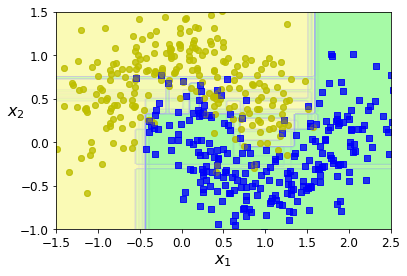

In [109]:
plt.figure(figsize=(6, 4))

for i in range(7):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(
        tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.2, contour=False)

plt.show()

Train a `RandomForestClassifiers` on the MNIST dataset:

In [110]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(mnist.data, mnist.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [114]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.hot, interpolation="nearest")
    # plt.axis("off")

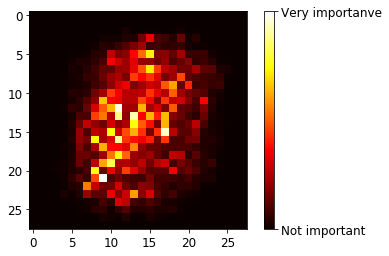

In [115]:
plot_digit(rf_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "Very importanve"])

plt.show()

## 4 Boost

### AdaBoost

In [116]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

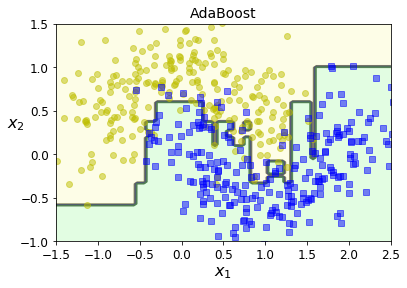

In [120]:
plot_decision_boundary(ada_clf, X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.title("AdaBoost", fontsize=14)
plt.show()

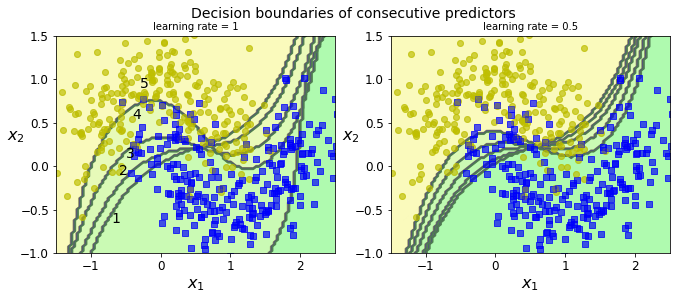

In [127]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2, axes=[-1.5, 2.5, -1, 1.5])
        plt.title("learning rate = {}".format(learning_rate), fontsize=10)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.suptitle("Decision boundaries of consecutive predictors", fontsize=14)
plt.show()

### Gradient Boosting

In [140]:
# Create a noisy quadratic training set
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

First, fit a `DecisionTreeRegressor` to the training set:

In [141]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Second, train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [142]:
y2 = y - tree_reg_1.predict(X)
tree_reg_2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_2.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Last, train a third regressor on the residual errors made by the second predictor:

In [143]:
y3 = y2 - tree_reg_2.predict(X)
tree_reg_3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_3.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now, we have an ensemble containing three trees. It can make predictions on a new instance simply adding up the predictions of all the trees:

In [144]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg_1, tree_reg_2, tree_reg_3))
y_pred

array([1.58570538])

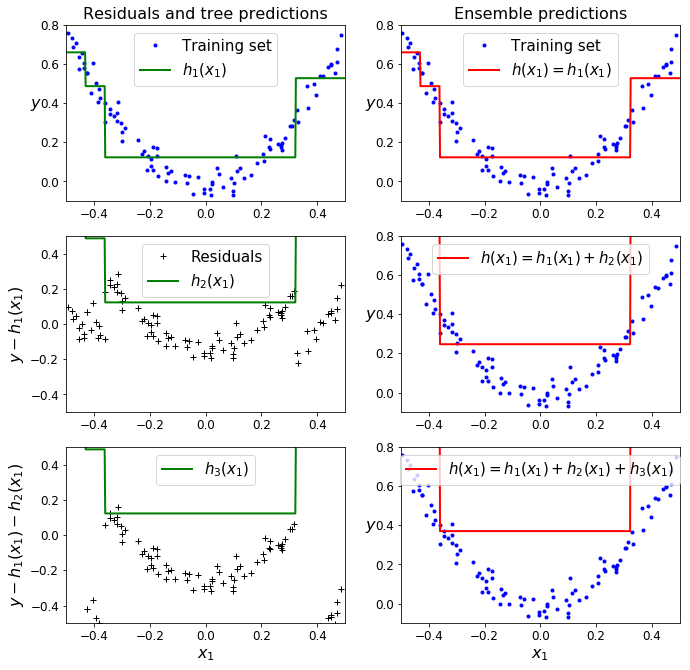

In [167]:
def plot_predictionsplot_pre(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg_2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$h_2(x_1)$", style="g-", data_style="k+",
                 data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg_1, tree_reg_2], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg_3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg_1, tree_reg_2, tree_reg_3], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()